In [0]:
!pip install keras


In [0]:
!pip install tensorflow

In [3]:
!pip install face_recognition


     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=6ef5ebbd83d2845f8aec7a8429a2016dada078a6237564c1c9fd0df1bd729d19
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MODEL FOR EMOTION **ANALYSIS**

In [0]:
import sys, os
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

df=pd.read_csv('/content/drive/My Drive/Colab/fer2013.csv')

# print(df.info())
# print(df["Usage"].value_counts())

# print(df.head())
X_train,train_y,X_test,test_y=[],[],[],[]

for index, row in df.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           train_y.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           test_y.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")


num_features = 64
num_labels = 7
batch_size = 64
epochs = 200
width, height = 48, 48


X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

train_y=np_utils.to_categorical(train_y, num_classes=num_labels)
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)

#cannot produce
#normalizing data between oand 1
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)

X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

# print(f"shape:{X_train.shape}")
##designing the cnn
#1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

# model.summary()

#Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

#Training the model
model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)

# saving file
import pickle
with open('/content/drive/My Drive/Colab/emotion-analysis-model.pkl','wb') as f:
  pickle.dump(model,f)


# SAVING MODEL AS PICKLE FILE

In [0]:
import pickle
with open('/content/drive/My Drive/Colab/emotion-analysis-model.pkl','wb') as f:
  pickle.dump(model,f)

# Checking if file exist or not  ?

In [1]:
import os
os.path.isfile('emotion-analysis-model.pkl')


False

In [0]:
import pickle 
with open('/content/drive/My Drive/Colab/emotion-analysis-model','rb') as f:
  model = pickle.load(f)

# CODE TO CHECK *IMAGES* 


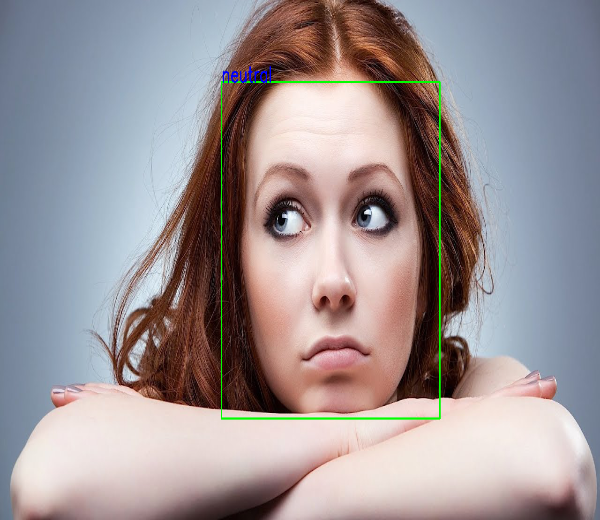

<function destroyAllWindows>

In [8]:
import os
import pickle
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from IPython.display import Image
import face_recognition
from google.colab.patches import cv2_imshow

#load model
# model = model_from_json(open("fer.json", "r").read())
#load weights
# model.load_weights('fer.h5')

with open('/content/drive/My Drive/Colab/emotion-analysis-model.pkl','rb') as f:
  model = pickle.load(f)

image_path = "/content/drive/My Drive/Colab/face_features_samples/sad2.jpg"
face_haar_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab/haarcascade_frontalface_default.xml')

test_img = face_recognition.load_image_file(image_path)

gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)


faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


for (x,y,w,h) in faces_detected:

    cv2.rectangle(test_img,(x,y),(x+w,y+h),(0,255,0),thickness=2)
    roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
    roi_gray=cv2.resize(roi_gray,(48,48))
    img_pixels = image.img_to_array(roi_gray)
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels /= 255

    predictions = model.predict(img_pixels)

    #find max indexed array
    max_index = np.argmax(predictions[0])

    emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    predicted_emotion = emotions[max_index]

    cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

resized_img = cv2.resize(test_img, (600, 520))
cv2_imshow(resized_img)

cv2.destroyAllWindows

In [0]:
from PIL import Image
import glob
import os

imdir = '/content/drive/My Drive/Colab/face_features_samples'
ext = ['png','jpg','jpeg']

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
print(files)
print("above loop")
for img_path in files:
        print("inside loop")
        image = Image.open(img_path)
        print(image)
        img_path = img_path.split("/")
        print(img_path)
